<a href="https://colab.research.google.com/github/yasminhegy-byte/now-ui-kit-react/blob/main/deepProject___(2)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Human Activity Recognition Using Wearable Sensor Data

Goal: Classify human activities (e.g., walking, sitting, etc.) using time-series sensor data.

Input: Sensor sequences (likely shape = (300 timesteps, 6 features) — probably 3-axis accelerometer + 3-axis gyroscope).

Output: One of several activity classes (multi-class classification)

#import libraries


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib.pyplot import figure
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.5 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
! pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download('https://www.kaggle.com/datasets/niloy333/kuhar?resource=download')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yasminosama202201683
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/niloy333/kuhar


In [ ]:
import pandas as pd
import os
import glob


df = pd.read_csv('/content/kuhar/3.Time_domain_subsamples/KU-HAR_time_domain_subsamples_20750x300.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802
0,0.004230,-0.000280,-0.013906,-0.002544,0.027433,0.058300,0.051670,0.071857,0.080653,0.047917,...,-0.016692,-0.018566,-0.017361,-0.017919,-0.016680,-0.016650,-0.013097,0,300,1
1,0.012482,0.032496,0.067856,0.071552,0.078103,0.040353,-0.001059,-0.018580,-0.026813,-0.011280,...,-0.008210,-0.010408,-0.011459,-0.011747,-0.010394,-0.008070,-0.004354,0,300,2
2,0.012127,0.028458,0.062075,0.052611,0.022942,-0.010017,-0.023151,-0.028515,0.005036,0.008450,...,0.000915,0.000771,-0.002560,-0.003020,-0.004190,0.000215,0.000850,0,300,3
3,0.052964,0.074319,0.110670,0.108490,0.091825,0.056989,0.029337,-0.016724,-0.042265,-0.053983,...,-0.001209,0.002878,0.000663,0.000982,-0.002148,-0.009200,-0.010653,0,300,4
4,-0.020462,-0.030787,-0.008617,0.008906,0.045046,0.042136,0.045037,0.045182,0.025113,0.021730,...,-0.006369,-0.006614,-0.004698,-0.007279,-0.006861,-0.006161,-0.006113,0,300,5


#data visualization

In [ ]:
dff = df.values
signals = dff[:, 0: 1800]                         #These are the time-domian subsamples (signals)
signals = np.array(signals, dtype=np.float32)
labels = dff[:, 1800]                             #These are their associated class labels (signals)

print(signals.shape)
print(labels.shape)

(20750, 1800)
(20750,)


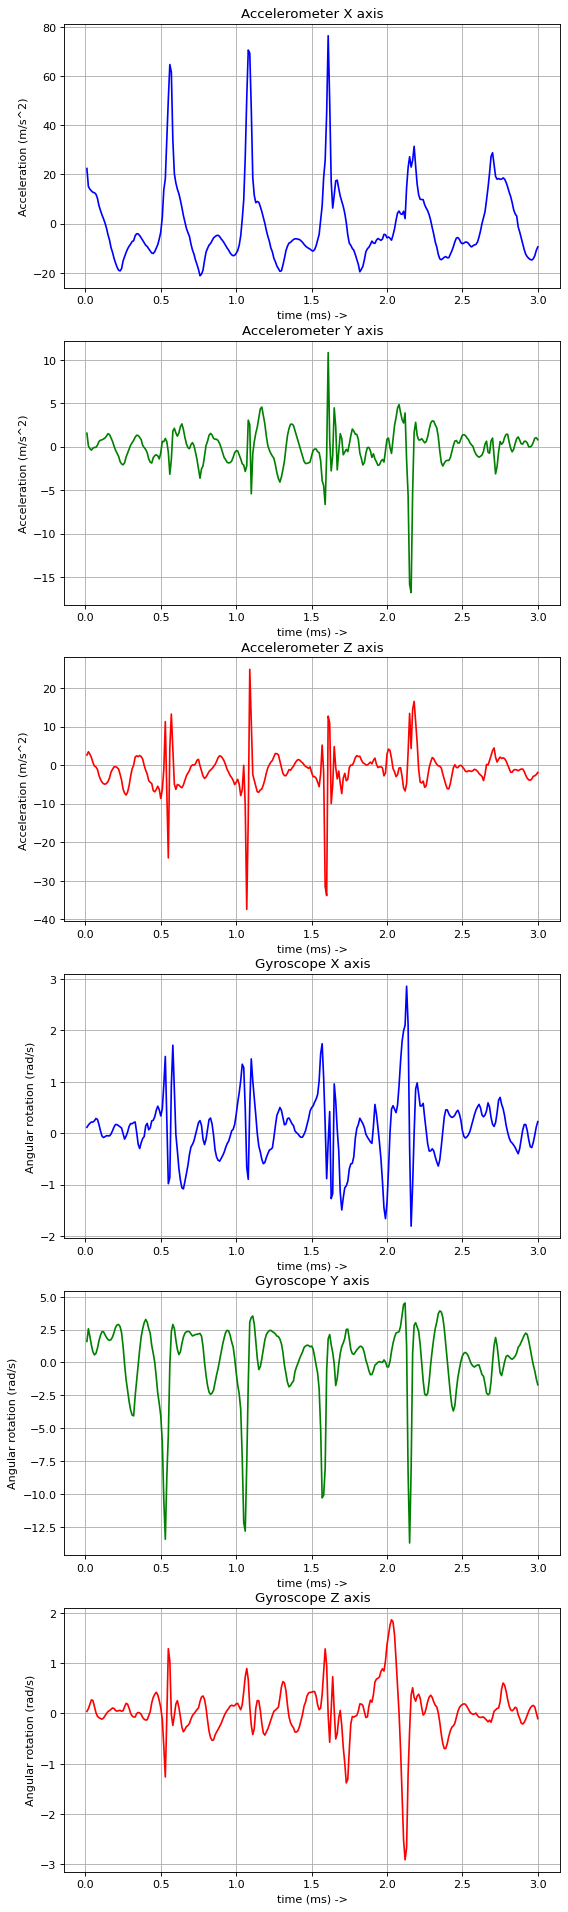

In [ ]:
# Visualization of the 20001th (time-domain HAR) sample (channel data):
# The correspondig activity is "Jump"

Accelerometer_X_axis_data = signals[20000, 0: 300]
Accelerometer_Y_axis_data = signals[20000, 300: 600]
Accelerometer_Z_axis_data = signals[20000, 600: 900]
Gyroscope_X_axis_data = signals[20000, 900: 1200]
Gyroscope_Y_axis_data = signals[20000, 1200: 1500]
Gyroscope_Z_axis_data = signals[20000, 1500: 1800]
time = np.linspace(.01, 3, 300)

figure(figsize=(8, 30), dpi=80)

ax1 = plt.subplot(611)
ax1.plot(time, Accelerometer_X_axis_data, 'b')
ax1.title.set_text('Accelerometer X axis')
ax1.set_xlabel('time (ms) ->')
ax1.set_ylabel('Acceleration (m/s^2)')
ax1.grid(True)

ax2 = plt.subplot(612)
ax2.plot(time, Accelerometer_Y_axis_data, 'g')
ax2.title.set_text('Accelerometer Y axis')
ax2.set_xlabel('time (ms) ->')
ax2.set_ylabel('Acceleration (m/s^2)')
ax2.grid(True)

ax3 = plt.subplot(613)
ax3.plot(time, Accelerometer_Z_axis_data, 'r')
ax3.title.set_text('Accelerometer Z axis')
ax3.set_xlabel('time (ms) ->')
ax3.set_ylabel('Acceleration (m/s^2)')
ax3.grid(True)

ax4 = plt.subplot(614)
ax4.plot(time, Gyroscope_X_axis_data, 'b')
ax4.title.set_text('Gyroscope X axis')
ax4.set_xlabel('time (ms) ->')
ax4.set_ylabel('Angular rotation (rad/s)')
ax4.grid(True)

ax5 = plt.subplot(615)
ax5.plot(time, Gyroscope_Y_axis_data, 'g')
ax5.title.set_text('Gyroscope Y axis')
ax5.set_xlabel('time (ms) ->')
ax5.set_ylabel('Angular rotation (rad/s)')
ax5.grid(True)

ax6 = plt.subplot(616)
ax6.plot(time, Gyroscope_Z_axis_data, 'r')
ax6.title.set_text('Gyroscope Z axis')
ax6.set_xlabel('time (ms) ->')
ax6.set_ylabel('Angular rotation (rad/s)')
ax6.grid(True)

plt.show()

#preproccessing

LSTMs work better with normalized data

In [ ]:
# Example using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(signals)

#data agumantation

create data agumantation function

1 **add_jitter:** why ?
Mimics real sensor noise: All physical sensors have slight measurement variations.

Prevents overfitting: Forces the LSTM to learn robust patterns instead of memorizing exact values.

Improves generalization: Helps the model work with different sensor hardware.

mechanism :
 Adds Gaussian noise with mean=0 and configurable standard deviation (noise_std=0.01 works well for sensor data in the range of my samples).
 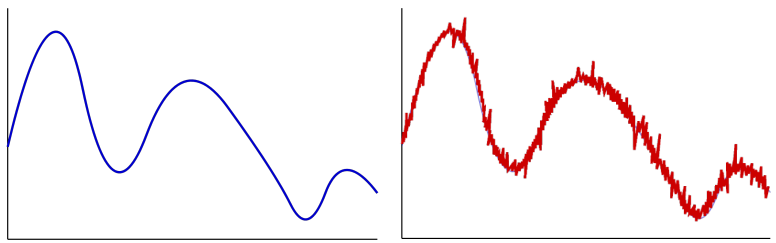

In [ ]:
def add_jitter(sequence, noise_std=0.01):
    noise = np.random.normal(loc=0.0, scale=noise_std, size=sequence.shape)
    return sequence + noise

2. **Time Warping** (time_warp)
Why?
Accounts for natural speed variations: Human movements (like sitting/standing) aren't perfectly uniform.

Makes timing-invariant: LSTM learns patterns regardless of slight speed changes.

Simulates different subjects: People perform activities at different speeds.

Example: A quick "sit-to-stand" motion might be stretched or compressed slightly.



In [ ]:
def time_warp(sequence, warp_factor=0.08):
    from scipy.interpolate import interp1d
    time_steps = np.arange(sequence.shape[0])
    random_warp = np.random.normal(loc=1.0, scale=warp_factor, size=sequence.shape[0])
    warped_time_steps = np.cumsum(random_warp)
    warped_time_steps = warped_time_steps * (sequence.shape[0] / warped_time_steps[-1])

    f = interp1d(warped_time_steps, sequence, axis=0, bounds_error=False, fill_value="extrapolate")
    return f(time_steps)

3. Sensor Dropout (sensor_dropout)
Why?
Simulates sensor failures: Real-world sensors may temporarily malfunction.

Encourages feature diversity: Prevents LSTM from over-relying on one sensor channel.

Improves robustness: Model learns to use all available sensors.

Example: An accelerometer's X-channel might be dropped for a few timesteps.

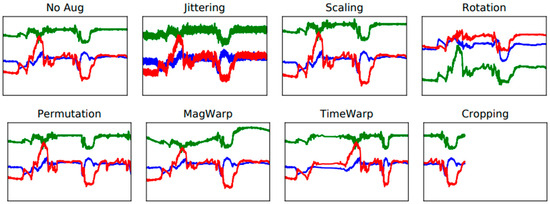

In [ ]:
def sensor_dropout(sequence, dropout_prob=0.1):
    mask = np.random.binomial(1, 1 - dropout_prob, sequence.shape)
    return sequence * mask


In [ ]:
def optimal_augmentation(sequence):
    sequence = add_jitter(sequence, noise_std=0.008)  # Mild noise
    sequence = time_warp(sequence, warp_factor=0.08)  # Subtle warping
    sequence = sensor_dropout(sequence, dropout_prob=0.07)  # Light dropout
    return sequence

#split and train

In [ ]:
X = df.iloc[:, :1800]
y = df.iloc[:, 1800]

X

,0,1,2,3,4,5,6,7,8,9,...,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799
0,0.004230,-0.000280,-0.013906,-0.002544,0.027433,0.058300,0.051670,0.071857,0.080653,0.047917,...,-0.007787,-0.010366,-0.015142,-0.016692,-0.018566,-0.017361,-0.017919,-0.016680,-0.016650,-0.013097
1,0.012482,0.032496,0.067856,0.071552,0.078103,0.040353,-0.001059,-0.018580,-0.026813,-0.011280,...,-0.005661,-0.006075,-0.007766,-0.008210,-0.010408,-0.011459,-0.011747,-0.010394,-0.008070,-0.004354
2,0.012127,0.028458,0.062075,0.052611,0.022942,-0.010017,-0.023151,-0.028515,0.005036,0.008450,...,0.004071,0.001735,0.000894,0.000915,0.000771,-0.002560,-0.003020,-0.004190,0.000215,0.000850
3,0.052964,0.074319,0.110670,0.108490,0.091825,0.056989,0.029337,-0.016724,-0.042265,-0.053983,...,-0.010183,-0.008949,-0.002526,-0.001209,0.002878,0.000663,0.000982,-0.002148,-0.009200,-0.010653
4,-0.020462,-0.030787,-0.008617,0.008906,0.045046,0.042136,0.045037,0.045182,0.025113,0.021730,...,-0.008344,-0.007853,-0.008526,-0.006369,-0.006614,-0.004698,-0.007279,-0.006861,-0.006161,-0.006113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20745,1.871600,1.648800,1.608900,1.802300,1.475000,1.390700,1.137800,1.289600,0.963750,1.022200,...,-0.410590,-0.480470,-0.538140,-0.497640,-0.432590,-0.414760,-0.363110,-0.329190,-0.460960,-0.621920
20746,1.889400,2.022700,0.817300,-0.505840,2.462200,3.814200,2.661000,2.651200,1.991400,4.427300,...,0.016722,-0.075675,-0.109470,-0.208820,-0.288930,-0.320880,-0.379540,-0.408210,-0.507970,-0.548040
20747,1.269500,1.312200,0.725570,0.531290,0.958420,-0.049679,1.223100,1.837000,0.989740,1.882600,...,1.550500,1.431600,1.382800,1.218500,1.125400,0.639470,0.277320,0.172710,-0.002894,0.023955
20748,-5.562200,-2.797000,-2.353300,-3.075600,-4.136100,-4.028800,-0.580260,0.346070,-2.631700,-2.790000,...,-0.573510,-0.572520,-0.439180,-0.246670,-0.209020,-0.128670,-0.104730,-0.131960,-0.150780,-0.187320


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# One-hot encode labels
num_classes = 18
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (16600, 1800)
Test data shape: (4150, 1800)


#Model Architecture

##LSTM

why LSTM?
Temporal modeling: LSTMs excel at capturing sequential patterns in sensor data accelerometer/gyroscope across 18 diverse activities—like transitions between sitting/standing or repetitive motions (push-ups, jumps) where timing and order are critical.

Multivariate handling: They automatically learn relationships between multiple sensor axes (X/Y/Z) and modalities (acceleration + rotation), crucial for distinguishing fine-grained activities (talk-sit vs. talk-stand or walk vs. walk-backward).

Robustness to noise: With built-in resistance to vanishing gradients and compatibility with time-series augmentations (jittering, warping), LSTMs manage real-world variability in motion speed, sensor noise, and participant differences.

Model Architecture: Two stacked LSTM layers (first returns sequences, second reduces to final hidden state), Dropout layers to reduce overfitting,Final dense layers map features to activity classes.

- Col. 1–300, 301–600, 601–900 ➞ Accelerometer X, Y, Z axes readings
- Col. 901–1200, 1201–1500, 1501–1800 ➞ Gyro X, Y, Z axes readings
- Col. 1801 ➞ Class ID (0 to 17, in the order mentioned above)

In [ ]:
# Reshape X from (samples, 1800) → (samples, 300 timesteps, 6 features)
X_train = X_train.values.reshape((-1, 300, 6))
X_test = X_test.values.reshape((-1, 300, 6))

In [ ]:
model = Sequential([
    LSTM(64, input_shape=(300, 6), return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.1),
    Dense(64, activation='relu'), #ideal for sensor data: accelerometer/gyroscope readings often have noise or near-zero values, which ReLU efficiently filters.
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # adam  optimizer has adaptive Learning Rates for Time-Series Data


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 300, 64)        │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 300, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,530 (220.82 KB)

 Trainable params: 56,530 (220.82 KB)

 Non-trainable params: 0 (0.00 B)

#Evaluation

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.1907 - loss: 2.3711 - val_accuracy: 0.2328 - val_loss: 2.0744
Epoch 2/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.2312 - loss: 2.1532 - val_accuracy: 0.2783 - val_loss: 1.8862
Epoch 3/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.2613 - loss: 1.9187 - val_accuracy: 0.3371 - val_loss: 1.7013
Epoch 4/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.3485 - loss: 1.6673 - val_accuracy: 0.3689 - val_loss: 1.6317
Epoch 5/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.3999 - loss: 1.5700 - val_accuracy: 0.4559 - val_loss: 1.3220
Epoch 6/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.4684 - loss: 1.3490 - val_accuracy: 0.5022 - val_loss: 1.2063
Epoch 7/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4184 - loss: 1.5871 - val_accuracy: 0.5422 - val_loss: 1.0837
Epoch 8/20
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5283 - loss: 1.1248 - val

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6978 - loss: 0.6516
Test accuracy: 0.6961


In [ ]:
y_pred_probs = model.predict(X_test)

# Convert one-hot encoded predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [ ]:
from sklearn.metrics import classification_report, f1_score
import numpy as np

f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print("F1 Score:", f1)

print(classification_report(y_true_classes, y_pred_classes))


F1 Score: 0.6620897227838023
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       377
           1       0.27      0.99      0.43       375
           2       0.81      0.21      0.33       359
           3       0.92      0.95      0.94       373
           4       0.99      0.94      0.96       436
           5       0.93      0.07      0.14       363
           6       0.99      0.94      0.97       352
           7       0.90      0.96      0.93       267
           8       1.00      0.96      0.98       133
           9       0.78      0.98      0.87        96
          10       0.95      0.95      0.95       201
          11       0.78      0.88      0.82       176
          12       0.53      0.51      0.52        63
          13       0.63      0.69      0.66        52
          14       0.96      0.94      0.95       119
          15       0.84      0.84      0.84       160
          16       0.94      0.65      0.77       15

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


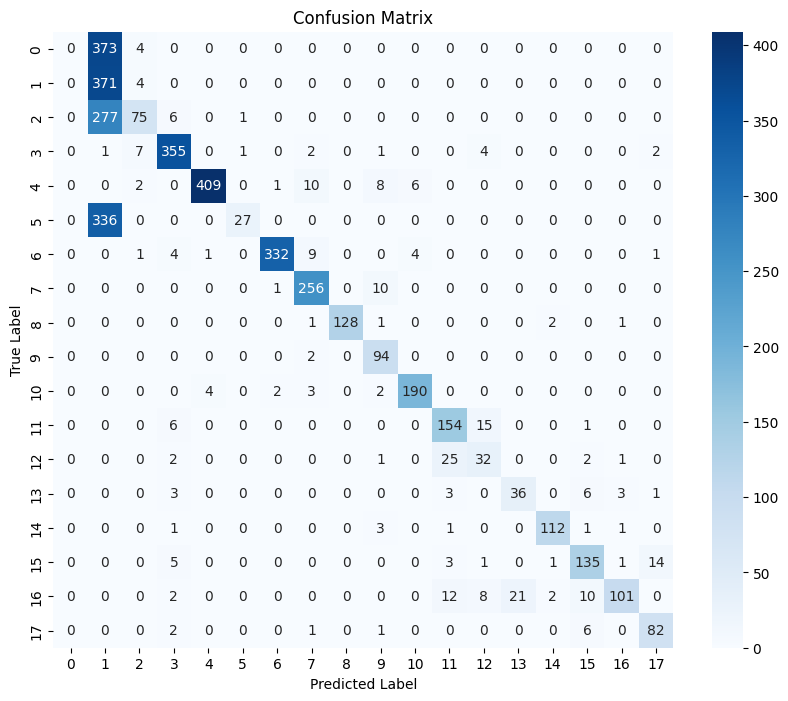

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Learning curves: train vs validation

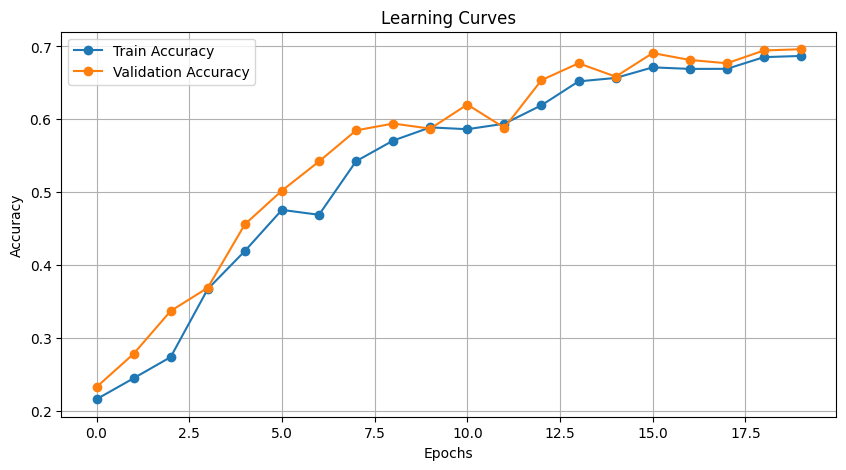

In [ ]:
# Plotting learning curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

find best val_accuracy epoch by tune model hyperparameters

In [ ]:
def build_model(hp):
    model = Sequential([
        LSTM(
            units=hp.Choice('lstm_units_1', values=[32, 64, 96]),
            input_shape=(300, 6),
            return_sequences=True
        ),
        Dropout(hp.Choice('dropout_1', values=[0.1, 0.2, 0.3])),
        LSTM(
            units=hp.Choice('lstm_units_2', values=[32, 64, 96])
        ),
        Dropout(hp.Choice('dropout_2', values=[0.1, 0.2, 0.3])),
        Dense(
            units=hp.Choice('dense_units', values=[32, 64, 128]),
            activation='relu'
        ),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    directory='my_dir',
    project_name='lstm_tuning'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


In [ ]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [ ]:
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_test, y_test),
             callbacks=[checkpoint, early_stopping])


Trial 3 Complete [00h 00m 45s]
val_accuracy: 0.45759037137031555

Best val_accuracy So Far: 0.45759037137031555
Total elapsed time: 00h 02m 09s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
96                |32                |lstm_units_1
0.2               |0.2               |dropout_1
64                |64                |lstm_units_2
0.1               |0.3               |dropout_2
128               |128               |dense_units
0.0001            |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
291/519 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.1308 - loss: 2.8080

Get the best hyperparameters from the tuning process


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- LSTM 1 units: {best_hps.get('lstm_units_1')}
- LSTM 2 units: {best_hps.get('lstm_units_2')}
- Dropout 1: {best_hps.get('dropout_1')}
- Dropout 2: {best_hps.get('dropout_2')}
- Dense units: {best_hps.get('dense_units')}
- Learning rate: {best_hps.get('learning_rate')}
""")


In [ ]:
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_model.save('har_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, f1_score
import numpy as np

model = load_model('best_model.h5')
y_pred_probs = model.predict(X_test)

# Convert to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

print(classification_report(y_true, y_pred))
